# CalMS21 end-to-end template

notebook to process CalMS21 data: index raw tracks, convert to standard format, compute features (pair distances/ego, wavelets, global t-SNE), cluster (KMeans/Ward), evaluate against ground truth, and train a local XGBoost behavior model. Fill in the paths/run_ids for your machine.

## Requirements & setup
- Update local dataset paths (e.g., `DATA_ROOT`/base dirs) before running cells.
- Expected roots under the dataset: `tracks_raw`, `tracks`, `labels`, `features`, `models`, `media`.
- Run sections in order: index/convert -> feature runs -> embeddings/clustering -> modeling.
- Outputs land in `features/<feature>/<run_id>` and `models/<model>/<run_id>`; reuse those run_ids downstream.


In [1]:
%load_ext autoreload
%autoreload 2
import json
from pathlib import Path
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt

from behavior.dataset import Dataset, BEHAVIOR_LABEL_MAP, save_inputset
from behavior import feature_library

## Dataset setup

In [9]:
from pathlib import Path
from behavior.dataset import Dataset, new_dataset_manifest, default_roots

DATA_ROOT = Path("/Volumes/JD-SSD/mice_data/calms21/dataset")
RAW_TRACKS_ROOT = DATA_ROOT / "raw"          # or wherever your raw files live

manifest_path = DATA_ROOT / "dataset.yaml"

# Allow a custom raw-tracks root in the manifest
roots = dict(default_roots)
roots["tracks_raw"] = str(RAW_TRACKS_ROOT)

if manifest_path.exists():
    dataset = Dataset(manifest_path).load()
    print("Loaded existing manifest:", manifest_path)
else:
    new_dataset_manifest(
        name="calms21",
        base_dir=DATA_ROOT,
        roots=roots,                       # includes tracks_raw
        index_format="group/sequence",
        outfile=manifest_path,
    )
    dataset = Dataset(manifest_path).load()
    print("Created manifest:", manifest_path)

GROUP_SCOPE = [g for g in dataset.list_groups() if "task1" in g]

Loaded existing manifest: /Volumes/JD-SSD/mice_data/calms21/dataset/dataset.yaml


## Index & convert CalMS21 tracks + labels

Run once after updating `DATA_ROOT` to your local paths and creating the dataset manifest

**Stage note:** Index/convert tracks and labels; writes to `tracks/`, `labels/` under your dataset roots. Run once after setting paths.


In [ ]:
# 1) Index raw CalMS21 npy/json files
dataset.index_tracks_raw(
    search_dirs=[dataset.roots["tracks_raw"]],
    patterns=("calms*.npy"),
    src_format="calms21_npy",
    group_from="filename",
    multi_sequences_per_file=True,
    recursive=True,
)

# 2) Convert to standardized trex-like parquet.  
# this is not needed if tracks are already in trex-like format
dataset.convert_all_tracks(
    params={"source_format": "calms21_npy"},
    overwrite=False,
    group_from="filename",
)

# 3) Convert ground-truth behavior labels
dataset.convert_all_labels(
    kind="behavior",
    source_format="calms21_npy",
    group_from="filename",
    overwrite=False,
)


## Core feature pipeline (CalMS21)

**Stage note:** Feature runs write under `features/<feature>/<run_id>`. Adjust params (pose/ego/wavelet) here and reuse printed run_ids downstream.


In [3]:
# Pair pose distance PCA (social distances)
pose_params = {"n_components": 6, "pose_n": 7}
feat_pose = feature_library.pairposedistancepca.PairPoseDistancePCA(params=pose_params)
pose_run = dataset.run_feature(feat_pose, input_kind="tracks", groups=GROUP_SCOPE)
print("pair-posedistance-pca run:", pose_run)

[feature:pair-posedistance-pca] completed run_id=0.1-7cca9bc234 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-posedistance-pca/0.1-7cca9bc234
pair-posedistance-pca run: 0.1-7cca9bc234


/Users/jacob/Documents/GitHub/EcodylicScience/behavior/src/behavior/dataset.py:3469: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)


In [4]:
egocentric_params = {"neck_idx": 3, "tail_base_idx": 6}
# Pair egocentric kinematics
feat_ego = feature_library.pair_egocentric.PairEgocentricFeatures(params=egocentric_params)
ego_run = dataset.run_feature(feat_ego, input_kind="tracks", groups=GROUP_SCOPE,
                              parallel_workers=4, parallel_mode="process")
print("pair-egocentric run:", ego_run)


[feature:pair-egocentric] completed run_id=0.1-77eaab4e6a -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-egocentric/0.1-77eaab4e6a
pair-egocentric run: 0.1-77eaab4e6a


/Users/jacob/Documents/GitHub/EcodylicScience/behavior/src/behavior/dataset.py:3469: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)


In [5]:
## wavelet transformations

# Config
wavelet_params = {
    "fps_default": 30.0,
    "f_min": 0.2,
    "f_max": 5.0,
    "n_freq": 25,
    "wavelet": "cmor1.5-1.0",
    "log_floor": -3.0,
}

# Wavelets on PCA (social)
feat_wave_social = feature_library.pair_wavelet.PairWavelet(params=wavelet_params)
social_wave_run = dataset.run_feature(
    feat_wave_social,
    input_kind="feature",
    input_feature="pair-posedistance-pca",
    input_run_id=pose_run,
    groups=GROUP_SCOPE,
    parallel_workers=4, parallel_mode="process"
)
print("pair-wavelet (social) run:", social_wave_run)

# Wavelets on egocentric (ego)
feat_wave_ego = feature_library.pair_wavelet.PairWavelet(params=wavelet_params)
ego_wave_run = dataset.run_feature(
    feat_wave_ego,
    input_kind="feature",
    input_feature="pair-egocentric",
    input_run_id=ego_run,
    groups=GROUP_SCOPE,
    parallel_workers=4, parallel_mode="process"
)
print("pair-wavelet (ego) run:", ego_wave_run)


[feature:pair-wavelet__from__pair-posedistance-pca] completed run_id=0.1-88d79630c2 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-wavelet__from__pair-posedistance-pca/0.1-88d79630c2
pair-wavelet (social) run: 0.1-88d79630c2
[feature:pair-wavelet__from__pair-egocentric] completed run_id=0.1-88d79630c2 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-wavelet__from__pair-egocentric/0.1-88d79630c2
pair-wavelet (ego) run: 0.1-88d79630c2


### Build inputset for global embeddings
Combine social wavelets (and optionally an ego wavelet run if you add one).

In [6]:
inputset_name = "social+ego"
inputset_inputs = [
        {
            "feature": "pair-wavelet__from__pair-posedistance-pca",
            "run_id": None,
            "pattern": "*.parquet",
            "load": {"kind": "parquet", "transpose": False},
        },
        {
            "feature": "pair-wavelet__from__pair-egocentric",
            "run_id": None,
            "pattern": "*.parquet",
            "load": {"kind": "parquet", "transpose": False},
        },
    ]
save_inputset(dataset, inputset_name, inputs=inputset_inputs, overwrite=True)


PosixPath('/Volumes/JD-SSD/mice_data/calms21/dataset/inputsets/social%2Bego.json')

## Global embedding and clustering

**Stage note:** Global t-SNE/clustering uses `tsne_feature = ...` before both KMeans and Ward. Outputs: `features/global-tsne__.../<run_id>`, `features/global-kmeans__.../<run_id>`, `features/global-ward__.../<run_id>`. Pick run_ids from `kmeans_runs` when plotting or assigning.


In [10]:
# Global t-SNE over inputset
tsne = feature_library.global_tsne.GlobalTSNE(params={
    "inputset": inputset_name,
    "total_templates": 2000,
    "perplexity": 50,
})
tsne_run = dataset.run_feature(tsne, input_kind="inputset", input_feature=inputset_name, groups=GROUP_SCOPE)
print("tsne run:", tsne_run)

[global-tsne] Mapped 10/89 sequences
[global-tsne] Mapped 20/89 sequences
[global-tsne] Mapped 30/89 sequences
[global-tsne] Mapped 40/89 sequences
[global-tsne] Mapped 50/89 sequences
[global-tsne] Mapped 60/89 sequences
[global-tsne] Mapped 70/89 sequences
[global-tsne] Mapped 80/89 sequences
[global-tsne] Mapped 89/89 sequences


[feature:global-tsne__from__social+ego] completed run_id=0.2-24cc0ae485 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-tsne__from__social+ego/0.2-24cc0ae485
tsne run: 0.2-24cc0ae485


/Users/jacob/Documents/GitHub/EcodylicScience/behavior/src/behavior/dataset.py:3469: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)


In [18]:
tsne_feature = f"{tsne.name}__from__{inputset_name}"

kmeans_runs = []
for k in [50, 100]:
    kmeans = feature_library.global_kmeans.GlobalKMeansClustering(params={
        "k": int(k),
        "artifact": {
            "feature": tsne_feature,
            "run_id": tsne_run,
            "pattern": "global_templates_features.npz",
            "load": {"kind": "npz", "key": "templates"},
        },
        "label_artifact_points": True,
        "assign": {
            "scaler": {
                "feature": tsne_feature,
                "run_id": tsne_run,
                "pattern": "global_opentsne_embedding.joblib",
                "key": "scaler", 
            },
            "inputset": inputset_name,  # use same inputs as TSNE mapping
        },
    })
    k_run = dataset.run_feature(
        kmeans,
        input_kind="feature",
        input_feature=tsne_feature,
        input_run_id=tsne_run,
        groups=GROUP_SCOPE,
    )
    kmeans_runs.append({"k": int(k), "run_id": k_run})
    print(f"k-means k={k} -> {k_run}")

kmeans_feature = f"global-kmeans__from__{tsne_feature}"


[feature:global-kmeans__from__global-tsne__from__social+ego] completed run_id=0.3-1c2c7afee7 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-kmeans__from__global-tsne__from__social+ego/0.3-1c2c7afee7
k-means k=50 -> 0.3-1c2c7afee7
[feature:global-kmeans__from__global-tsne__from__social+ego] completed run_id=0.3-58afc8e1a7 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-kmeans__from__global-tsne__from__social+ego/0.3-58afc8e1a7
k-means k=100 -> 0.3-58afc8e1a7


Tip: `kmeans_runs` holds multiple runs; select a specific `run_id` (e.g., `kmeans_runs[0]['run_id']`) when you need a stable reference.


In [19]:
tsne_feature = f"{tsne.name}__from__{inputset_name}"

# Run Ward clustering on TSNE templates
ward = feature_library.global_ward.GlobalWardClustering(params={
    "artifact": {
        "feature": tsne_feature,
        "run_id": tsne_run,
        "pattern": "global_templates_features.npz",
        "load": {"kind": "npz", "key": "templates"},
    },
    "method": "ward",
})
ward_run = dataset.run_feature(
    ward,
    input_kind="feature",
    input_feature=tsne_feature,
    input_run_id=tsne_run,
    groups=GROUP_SCOPE,
)
print("ward run:", ward_run)

ward_feature = f"global-ward__from__{tsne_feature}"

ward_assign_runs = []
for cut in [25,50,100]:
    assign = feature_library.ward_assign.WardAssignClustering(params={
        "ward_model": {
            "feature": ward_feature,
            "run_id": ward_run,
            "pattern": "model.joblib",
        },
        "artifact": {
            "feature": tsne_feature,
            "run_id": tsne_run,
            "pattern": "global_templates_features.npz",
            "load": {"kind": "npz", "key": "templates"},
        },
        "scaler": {
            "feature": tsne_feature,
            "run_id": tsne_run,
            "pattern": "global_opentsne_embedding.joblib",
            "key": "scaler",
        },
        "inputset": inputset_name,
        "n_clusters": int(cut),
        "recalc": False,
    })
    assign_run = dataset.run_feature(
        assign,
        input_kind="inputset",
        input_feature=inputset_name,
        groups=GROUP_SCOPE,
        parallel_workers=3

    )
    ward_assign_runs.append({"n_clusters": int(cut), "run_id": assign_run})
    print(f"ward-assign k={cut} -> {assign_run}")

ward_assign_feature = f"ward-assign__from__{ward_feature}"
last_ward_assign_run = ward_assign_runs[-1]["run_id"] if ward_assign_runs else None


[feature:global-ward__from__global-tsne__from__social+ego] completed run_id=0.1-8d32781548 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-ward__from__global-tsne__from__social+ego/0.1-8d32781548
ward run: 0.1-8d32781548
[feature:ward-assign__from__global-ward__from__global-tsne__from__social+ego] completed run_id=0.1-930fc93388 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/ward-assign__from__global-ward__from__global-tsne__from__social+ego/0.1-930fc93388
ward-assign k=25 -> 0.1-930fc93388
[feature:ward-assign__from__global-ward__from__global-tsne__from__social+ego] completed run_id=0.1-5c53f01fa2 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/ward-assign__from__global-ward__from__global-tsne__from__social+ego/0.1-5c53f01fa2
ward-assign k=50 -> 0.1-5c53f01fa2
[feature:ward-assign__from__global-ward__from__global-tsne__from__social+ego] completed run_id=0.1-7d911460f0 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/ward-assign__from__global-ward__from__

## Cluster/label agreement (GT vs clusters)

Exploratory data analysis step

In [20]:
from behavior.analysis import compute_cluster_label_agreement

kmeans_feature = f"global-kmeans__from__{tsne_feature}"
run_id = kmeans_runs[0]["run_id"]  # or pick the one you want

agr = compute_cluster_label_agreement(
    dataset,
    cluster_feature=kmeans_feature,
    cluster_run_id=run_id,
    label_kind="behavior",
    sequences=None,
)
agr


{'cluster_feature': 'global-kmeans__from__global-tsne__from__social+ego',
 'cluster_run_id': '0.3-1c2c7afee7',
 'label_kind': 'behavior',
 'n_sequences': 89,
 'n_frames_total': 769845,
 'n_frames_used': 769845,
 'sampled': False,
 'metrics': {'n_samples': 769845,
  'n_classes': 4,
  'n_clusters': 50,
  'ARI': 0.04817445678007516,
  'AMI': 0.15189092878670293,
  'homogeneity': 0.32067477187485366,
  'completeness': 0.09954743708272683,
  'v_measure': 0.15193081658590865,
  'purity': 0.7164039514447713,
  'hungarian_accuracy': 0.1895615351142113,
  'confusion': array([[  131,     0,   154,   245,   806,  4084,     0,   985,     0,
            235,    46,   734,     0,   100,   335,    45,    30,  1641,
             35,  1902,     0,   427,     0,     0,   374,  2672,  1384,
              6,   212,    52,     0,    31,     6,     0,     0,   285,
           3457,     0,   194,   821,     0,    58,    45,  3110,   618,
            825,     0,   188,   393,     3],
         [ 1624,  3278,  

## Visualizations (GT + clusters on t-SNE)

[feature:viz-global-colored] failed to save params.json: Object of type object is not JSON serializable
[viz-global-colored] INFO: labels shorter than coords for key=task1%2Ftest%2Fmouse071_task1_annotator1 (23810 vs 47620); repeating labels x2 (likely per-id/perspective duplication in inputs).
[viz-global-colored] INFO: labels shorter than coords for key=task1%2Ftest%2Fmouse072_task1_annotator1 (18164 vs 36328); repeating labels x2 (likely per-id/perspective duplication in inputs).
[viz-global-colored] INFO: labels shorter than coords for key=task1%2Ftest%2Fmouse073_task1_annotator1 (19156 vs 38312); repeating labels x2 (likely per-id/perspective duplication in inputs).
[viz-global-colored] INFO: labels shorter than coords for key=task1%2Ftest%2Fmouse074_task1_annotator1 (18825 vs 37650); repeating labels x2 (likely per-id/perspective duplication in inputs).
[viz-global-colored] INFO: labels shorter than coords for key=task1%2Ftest%2Fmouse075_task1_annotator1 (18015 vs 36030); repeati

[feature:viz-global-colored__from__global-tsne__from__social+ego] completed run_id=0.1-67349e78f0 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/viz-global-colored__from__global-tsne__from__social+ego/0.1-67349e78f0
viz GT run: 0.1-67349e78f0


[feature:viz-global-colored] failed to save params.json: Object of type object is not JSON serializable


[feature:viz-global-colored__from__global-tsne__from__social+ego] completed run_id=0.1-5d8131abcf -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/viz-global-colored__from__global-tsne__from__social+ego/0.1-5d8131abcf
viz kmeans run: 0.1-5d8131abcf


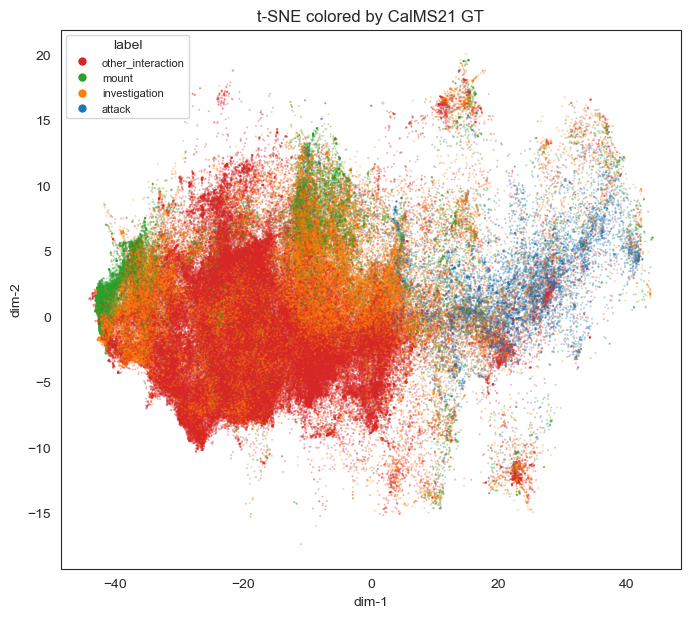

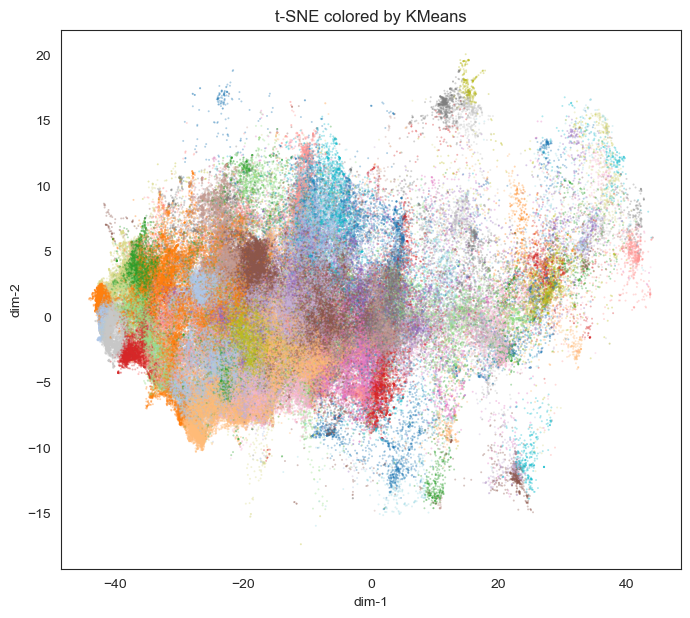

In [22]:
tsne_feature = f"{tsne.name}__from__{inputset_name}"
kmeans_feature = f"global-kmeans__from__{tsne_feature}"
kmeans_run_id = kmeans_runs[-1]["run_id"]  # or choose a specific one

viz_gt = feature_library.viz_global_colored.VizGlobalColored(params={
    "coords": {
        "feature": tsne_feature,
        "run_id": tsne_run,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {"source": "labels", "kind": "behavior", "load": {"kind": "npz", "key": "labels"}},
    "title": "t-SNE colored by CalMS21 GT",
    "label_order": list(BEHAVIOR_LABEL_MAP.keys()),
    "label_name_map": BEHAVIOR_LABEL_MAP,
    "palette": sns.color_palette("tab10", len(BEHAVIOR_LABEL_MAP)),
})
viz_gt_run = dataset.run_feature(
    viz_gt,
    input_kind="feature",
    input_feature=tsne_feature,
    groups=GROUP_SCOPE,
    overwrite=True,
)
print("viz GT run:", viz_gt_run)

viz_km = feature_library.viz_global_colored.VizGlobalColored(params={
    "coords": {
        "feature": tsne_feature,
        "run_id": tsne_run,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {
        "feature": kmeans_feature,
        "run_id": kmeans_run_id,
        "pattern": "global_kmeans_labels_seq=*.npz",
        "load": {"kind": "npz", "key": "labels"},
    },
    "title": "t-SNE colored by KMeans",
})
viz_km_run = dataset.run_feature(
    viz_km,
    input_kind="feature",
    input_feature=tsne_feature,
    groups=GROUP_SCOPE,
    overwrite=True,
)
print("viz kmeans run:", viz_km_run)


## Model training (local XGBoost)

**Stage note:** You can train on a single feature (`feature` + `feature_run_id`) or via an `inputset`. Record `ts_stack_run` / `stack_inputset` so prediction cells can reuse them.


### Temporal stack feature for model input

In [23]:
# Smoke test: slicing to a small subset; remove the slices for full training
# Build explicit splits
train_seqs = [s for s in dataset.list_sequences() if "task1/train" in s]
test_seqs  = [s for s in dataset.list_sequences() if "task1/test" in s]

# for a test fit, just key a subset (remove this to fit on full dataset)
train_seqs = train_seqs[3:4]
test_seqs = test_seqs[3:4]

In [24]:
# Temporal stack over wavelet features
ts_stack = feature_library.temporal_stacking.TemporalStackingFeature(params={
    "inputset": inputset_name,
    "half": 2, "skip": 1,
    "use_temporal_stack": True,
    "sigma_stack": 2,
    "add_pool": False, "pool_stats": ("mean",),
    "fps": 30.0
})
ts_stack_run = dataset.run_feature(ts_stack, input_kind="inputset", input_feature=inputset_name, 
                                   groups=GROUP_SCOPE, sequences=(train_seqs+test_seqs),
                                   parallel_workers=4, parallel_mode="thread")
print("temporal-stack run:", ts_stack_run)

[feature:temporal-stack__from__social+ego] completed run_id=0.1-e04567e9e1 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/temporal-stack__from__social+ego/0.1-e04567e9e1
temporal-stack run: 0.1-e04567e9e1


/Users/jacob/Documents/GitHub/EcodylicScience/behavior/src/behavior/dataset.py:2366: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)


In [26]:
# Verify temporal-stack outputs exist
## fit model
stack_feature = f"{ts_stack.storage_feature_name}__from__{inputset_name}"

print('temporal-stack run root:', dataset.get_root('features') / stack_feature / ts_stack_run)
print((dataset.get_root('features') / stack_feature / ts_stack_run).exists())


temporal-stack run root: /Volumes/JD-SSD/mice_data/calms21/dataset/features/temporal-stack__from__social+ego/0.1-e04567e9e1
True


### Fit model using feature as input

In [27]:
from behavior.model_library.behavior_xgboost import BehaviorXGBoostModel

## fit model
stack_feature = f"{ts_stack.storage_feature_name}__from__{inputset_name}"

xgb_model = BehaviorXGBoostModel()
xgb_model.bind_dataset(dataset)

run_root = dataset.get_root("models") / xgb_model.name / "calms21-local"
run_root.mkdir(parents=True, exist_ok=True)

xgb_config = {
    "feature": stack_feature,   # temporal-stack feature name
    "feature_run_id": ts_stack_run,
    "label_kind": "behavior",
    "train_sequences": train_seqs,
    "test_sequences": test_seqs,
    "random_state": 43,
    "classes": [0, 1, 2, 3],
    "label_map": {0: "attack", 1: "investigation", 2: "mount", 3: "other"},
    "standardize": True,
    "use_undersample": True,
    "undersample_ratio": 3.0,
    "use_smote": False,
    "xgb_params_preset": "xgb_v0",
    "use_external_memory": False,
}

xgb_model.configure(xgb_config, run_root)
train_summary = xgb_model.train()
json.dump(train_summary, open(run_root / "train_summary.json", "w"), indent=2)
train_summary


[behavior-xgb] WARN: no positives for class 0; skipping.


/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:36:06] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:37:00] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:37:39] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


{'classes_trained': [1, 2, 3],
 'n_train_samples': 7433,
 'n_test_samples': 18825,
 'summary_csv': '/Volumes/JD-SSD/mice_data/calms21/dataset/models/behavior-xgb/calms21-local/summary.csv',
 'reports_json': '/Volumes/JD-SSD/mice_data/calms21/dataset/models/behavior-xgb/calms21-local/reports.json',
 'models_path': '/Volumes/JD-SSD/mice_data/calms21/dataset/models/behavior-xgb/calms21-local/models.joblib',
 'train_sequences': ['task1%2Ftrain%2Fmouse004_task1_annotator1'],
 'test_sequences': ['task1%2Ftest%2Fmouse074_task1_annotator1']}

In [28]:
# Verify model outputs exist
print('model run root:', run_root)
print('models present:', (run_root / 'models.joblib').exists())


model run root: /Volumes/JD-SSD/mice_data/calms21/dataset/models/behavior-xgb/calms21-local
models present: True


In [29]:
# 1) Quick per-class metrics table
summary_df = pd.read_csv(run_root / "summary.csv")
display(summary_df.sort_values("behavior"))

# 2) Full reports + confusion matrices
with open(run_root / "reports.json") as f:
    reports = json.load(f)

conf_mats = {
    int(cls): np.array(payload["confusion_matrix"])
    for cls, payload in reports.items()
}

# for cls, cm in conf_mats.items():
#     print(f"\nBehavior {cls} confusion matrix (rows=true, cols=pred):")
#     display(pd.DataFrame(cm, index=["neg", "pos"], columns=["neg", "pos"]))

macro_f1 = np.mean([
    payload["report"][str(cls)]["f1-score"]
    for cls, payload in reports.items()
])
print(f"Macro F1: {macro_f1:.3f}")

,behavior,precision,recall,f1,support,average_precision
0,1,0.562284,0.090403,0.155763,3595.0,0.397949
1,2,0.693478,0.144803,0.239579,2203.0,0.536251
2,3,0.798227,0.967529,0.874761,13027.0,0.939804


Macro F1: 0.423


### Predict using feature

In [30]:
# Predict back onto temporal-stack features
predict_feat = feature_library.model_predict.ModelPredictFeature(params={
    "model_class": "behavior.model_library.behavior_xgboost.BehaviorXGBoostModel",
    "model_run_id": "calms21-local",
    "model_name": xgb_model.name,
    "output_feature_name": f"{xgb_model.name}-pred",
})
pred_run = dataset.run_feature(predict_feat, input_kind="feature", input_feature=stack_feature, input_run_id=ts_stack_run, 
                               groups=GROUP_SCOPE)
print("prediction run:", pred_run)

# Overlay predictions on video (optional) via visualization.play_video/play_frames utilities

[feature:behavior-xgb-pred__from__temporal-stack__from__social+ego] completed run_id=0.1-60303398b5 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/behavior-xgb-pred__from__temporal-stack__from__social+ego/0.1-60303398b5
prediction run: 0.1-60303398b5


### Other method: create inputset and train model on inputset
Here, this does the same fits, because the inputset only contains one feature.  

Note that could also train the model directly on the social+ego input, i.e. without temporal stacking

In [31]:
# 1) Build an inputset pointing to the temporal-stack run
stack_feature = f"{ts_stack.storage_feature_name}__from__{inputset_name}"  # e.g. "temporal-stack__from__social+ego"
stack_inputset = f"{stack_feature}__{ts_stack_run}"                       # name it however you like

inputs = [
    {
        "feature": stack_feature,
        "run_id": ts_stack_run,
        "pattern": "*.parquet",
        "load": {
            "kind": "parquet",
            "drop_columns": ["frame", "group", "sequence"],
            "numeric_only": True,
        },
        "name": "temporal_stack",
    },
]
save_inputset(dataset, stack_inputset, inputs, overwrite=True)
print("Inputset saved:", stack_inputset)

Inputset saved: temporal-stack__from__social+ego__0.1-e04567e9e1


In [32]:
# 3) Configure/train model using the inputset
xgb_model = BehaviorXGBoostModel()
xgb_model.bind_dataset(dataset)

run_root = dataset.get_root("models") / xgb_model.name / "calms21-local"
run_root.mkdir(parents=True, exist_ok=True)

xgb_config = {
    "inputset": stack_inputset,   # use the inputset instead of feature/feature_run_id
    "label_kind": "behavior",
    "train_sequences": train_seqs,
    "test_sequences": test_seqs,
    "random_state": 43,
    "classes": [0, 1, 2, 3],
    "label_map": {0: "attack", 1: "investigation", 2: "mount", 3: "other"},
    "standardize": True,
    "use_undersample": True,
    "undersample_ratio": 3.0,
    "use_smote": False,
    "xgb_params_preset": "xgb_v0",
    "use_external_memory": False,
}

xgb_model.configure(xgb_config, run_root)
train_summary = xgb_model.train()
(run_root / "train_summary.json").write_text(json.dumps(train_summary, indent=2))
print("trained run_root:", run_root)
print(train_summary)


[behavior-xgb] WARN: no positives for class 0; skipping.


/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:38:47] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:39:39] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:40:19] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


trained run_root: /Volumes/JD-SSD/mice_data/calms21/dataset/models/behavior-xgb/calms21-local
{'classes_trained': [1, 2, 3], 'n_train_samples': 7433, 'n_test_samples': 18825, 'summary_csv': '/Volumes/JD-SSD/mice_data/calms21/dataset/models/behavior-xgb/calms21-local/summary.csv', 'reports_json': '/Volumes/JD-SSD/mice_data/calms21/dataset/models/behavior-xgb/calms21-local/reports.json', 'models_path': '/Volumes/JD-SSD/mice_data/calms21/dataset/models/behavior-xgb/calms21-local/models.joblib', 'train_sequences': ['task1%2Ftrain%2Fmouse004_task1_annotator1'], 'test_sequences': ['task1%2Ftest%2Fmouse074_task1_annotator1']}


### Predict using the inputset


In [33]:
# Names from training
run_root = dataset.get_root("models") / "behavior-xgb" / "calms21-local"
stack_inputset = f"{stack_feature}__{ts_stack_run}"   # the inputset you saved
# stack_feature and ts_stack_run already defined above

# Load trained model and inspect expected schema
model = BehaviorXGBoostModel()
model.bind_dataset(dataset)
model.load_trained_model(run_root)

# Predict using the inputset
predict_feat = feature_library.model_predict.ModelPredictFeature(params={
    "model_class": "behavior.model_library.behavior_xgboost.BehaviorXGBoostModel",
    "model_run_id": "calms21-local",               # folder under models/behavior-xgb/
    "model_name": "behavior-xgb",
    "output_feature_name": "behavior-xgb-pred",
})
pred_run = dataset.run_feature(
    predict_feat,
    input_kind="inputset",
    input_feature=stack_inputset,                  # use the saved inputset
    groups=GROUP_SCOPE,
    overwrite=True,
)
print("prediction run:", pred_run)


[feature:behavior-xgb-pred__from__temporal-stack__from__social+ego__0.1-e04567e9e1] completed run_id=0.1-60303398b5 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/behavior-xgb-pred__from__temporal-stack__from__social+ego__0.1-e04567e9e1/0.1-60303398b5
prediction run: 0.1-60303398b5
